In [1]:
import nengo
import nengo_spa as spa
import pytry
import numpy as np
from random import shuffle
import random
import sys, os
import math
from IPython import display
from scipy.optimize import brute, minimize

import skopt
from skopt import gp_minimize
from skopt.space.space import Integer, Real
from skopt.plots import plot_evaluations, plot_objective

from scipy.stats import sem
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as style
import pickle
import os

from itertools import product



# Import our classes
sys.path.append('..')
import experiments as xps
from experiments import create_xp
from model import ExperimentRun, create_vocab
from data import Data

# Optimization and model parameters

In [2]:
D = int(96)  # the dimensionality of the vectors
PROC_FDBCK = .9
PROC_FDBCK_SYN = .005
GW_FDBCK = 1
GW_SCALE = 20 # scale the input of GW for saturation and catching very short visual stimuli
BG_THR = .1
BG_BIAS = .5
STIM_DURATION = .029
FIX_DURATION = .5
N_NEURONS_SCALE = 1
N_NEURONS_SCALE_COMBINED = .25
INTEGRATOR_RESET = False
N_SAMPLES = 10000

STARTING_SEED = 1
N_SEEDS = 10

N_BLOCKS_PER_OPERATION = 1 # default: 10
N_TRIALS_PER_DIGIT = 2 # default: 5
N_DIFFERENT_DIGITS = 4 # default: 4
N_DIFFERENT_OPERATIONS = 3 # default: 3

data_dir = "evaluate_fit/big_optimization_2"


In [3]:
# opt_res = skopt.load(data_dir+'/optimization_results.pickle')

def create_evaluation_function(loss='rmse', plot=False, starting_seed=STARTING_SEED, n_seeds=N_SEEDS, compare_errorates=True, compare_RTs=True):
    
    def evaluation_function(params):
    
        print("params:", params)
        data = []

        D = params[6]*16

    #     return 0

        print('Simulating...')
        for i,seed in enumerate(range(starting_seed, starting_seed+n_seeds)):
            print('\t seed '+str(i+1)+'/'+str(n_seeds))
            data_filename = 'run_seed'+str(seed)+'_crosstalk'+str(params[0])+'_sevid'+str(params[1])+'_nsamples'+str(params[3])+'_combscale'+str(params[4])+'_procfb'+str(params[5])+'_D'+str(D)+'_gwscale'+str(params[7])+'_prevsyn'+str(params[8])      

            try:
                seed_data = pd.read_pickle(data_dir+'/'+data_filename+'.csv')

            except FileNotFoundError:
                xp = create_xp(N_BLOCKS_PER_OPERATION, N_TRIALS_PER_DIGIT, N_DIFFERENT_DIGITS, N_DIFFERENT_OPERATIONS, STIM_DURATION, FIX_DURATION, seed)
                results = ExperimentRun().run(
                    n_neurons_scale=N_NEURONS_SCALE,
                    n_neurons_scale_combined=params[4],
                    s_crosstalk=params[0],
                    s_evidence=params[1],
                    n_samples=int(params[3]),
                    t_senso=0,
                    vocab=create_vocab(D, seed),
                    xp=xp,
                    integrator_reset=INTEGRATOR_RESET,
                    proc_feedback=params[5],
                    proc_feedback_synapse=PROC_FDBCK_SYN,
                    prev_feedback_synapse=params[8],
                    GW_feedback=GW_FDBCK,
                    GW_scale=params[7],
                    BG_thr=BG_THR,
                    BG_bias=BG_BIAS,
                    seed=seed,
                    backend="nengo_ocl",
                    data_dir=data_dir,
                    data_filename=data_filename,
                    plt=False
                )

                seed_data = results['data'].df

                seed_data.to_pickle(data_dir+'/'+data_filename+'.csv')
            data.append(seed_data)


        data = Data(pd.concat(data))
        data.df['rt'] += params[2]*1000
        if loss == 'rmse':
            error = data.mean_differences_error(compare_errorrates=compare_errorates, compare_RTs=compare_RTs, tasks=range(N_DIFFERENT_OPERATIONS))
        elif loss == 'error rate':
            error = data.error_rate
        else:
            error = 0
        
        print(loss, ':', error)

        if plot:
            data.plot_fig2_simple(plot_humans=True, save_file=data_dir+'/'+data_filename, errorates=False)
            data.plot_fig2_chained(plot_humans=True, save_file=data_dir+'/'+data_filename, errorates=False)
        
        return error
    
    return evaluation_function

In [39]:
rmse_res = gp_minimize(create_evaluation_function(), 
    dimensions=[
        Real(0, 1, name="crosstalk"), # crosstalk
        Real(5, 20, name="evidence strength"), # evidence strength
        Real(0, .2, name="senso"), # sensory delay
        Integer(100, 10000, name="number of samples"), # number of samples
        Real(.1, 1, name="scale combined"), # n_neurons_scale_combined
        Real(.5, 1, name="processor feedback"), # processor feedback
        Integer(2, 10, name="dimensions"), # dimensions (*16)
        Real(1, 30, name="GW scale"), # GW scale
        Real(.002, .02, name="PREV feedback synapse"), # PREV feedback synapse
    ],
#     x0=[
#         .15, # crosstalk
#         15, # evidence strength
#         .1, # sensory delay
#         N_SAMPLES,
#         N_NEURONS_SCALE_COMBINED,
#         PROC_FDBCK,
#         int(D/16),
#         GW_SCALE,
#         .01 # prev fb syn
#     ],
    n_calls=100,
    random_state=STARTING_SEED,
    x0=res['x_iters'],
    n_random_starts=0,
               
)

with open(data_dir+"/rmse_res.pickle", 'wb') as handle:
    pickle.dump(rmse_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

params: [0.15, 15, 0.1, 10000, 0.25, 0.9, 6, 20, 0.01]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 40.03263923191786
params: [0.9971848109388688, 18.988360390079883, 0.025624889585871353, 9991, 0.3124800792567785, 0.6982903636480131, 5, 20.422635067300924, 0.018839703274508582]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 45.859745043411586
params: [0.8463109166860173, 9.699102753984128, 0.10490963191457431, 4490, 0.30661949235684305, 0.7672069544735085, 9, 14.258939431622663, 0.009752574209324755]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 43.96436692450899
params: [0.939127789423626, 16.675838545048006, 0.14319410319367287, 8047, 0.18352072777666414, 0.7590762744709445, 9, 25.045260313647113, 0.

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1015.8248687751452
params: [0.5613352988590182, 17.731538807746944, 0.17072091200961292, 7678, 0.6593016016663453, 0.9426975472221037, 2, 17.84715279246152, 0.01392493673208171]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 123.85441409033345
params: [0.7713357115137491, 8.667775693653798, 0.06678057625529042, 6242, 0.7414523339689285, 0.6139845660866255, 9, 22.701383700927728, 0.016812095128170133]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 48.16113879131324
params: [0.0, 20.0, 0.0, 100, 1.0, 0.5, 2, 30.0, 0.002]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 131.91492540435053
params: [0.0, 5.0, 0.0, 100, 0.1, 0.5, 2, 1.0, 0.002]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1060.0773850280043
params: [0.8363759500445652, 5.180478297959942, 0.11781422258843849, 2746, 0.25101694187229084, 0.6218165251087711, 10, 10.32572376300571, 0.018890228182317614]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 95.16455338993158
params: [0.9845047350796741, 8.861682317186377, 0.0924949472932723, 4258, 0.41626494963892935, 0.6251645074311933, 6, 25.363170945646615, 0.0033221846909577933]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 66.26657628660024
params: [0.8804125487915851, 14.010087647943466, 0.05912967302468012, 964, 0.13969858002717248, 0.6821303779923132, 8, 4.787023814530521, 0.00391460390847916]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 75.34188800934056
params: [0.97

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 877.1935359938807
params: [0.7689836785894881, 5.865972959345958, 0.07681294116548443, 2967, 0.27731650278211584, 0.5296000156107522, 8, 7.9437175139958685, 0.0030019865636921835]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 55.697895963198555
params: [0.5917980958918169, 8.324410143277264, 0.05693926009001748, 7351, 0.8891950596888468, 0.9955319335576123, 6, 27.662779816061164, 0.01367886749149185]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 61.03391111558309
params: [0.9424065439252352, 18.81906112974604, 0.02711591153658653, 1847, 0.9429329378754151, 0.937691029675547, 5, 2.2992186151820206, 0.01816064197746782]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 70.6698230822248
params: [0.80893

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 307.6193952517528
params: [0.8341314493043362, 8.317708875152386, 0.06568204739566329, 6784, 0.4476390160278807, 0.9984200897645914, 4, 22.626887099339495, 0.0032088256169074073]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 307.60266959997284
params: [0.8733180849349123, 13.312279867708797, 0.12402602637560184, 1377, 0.7444200784558392, 0.7606842768863016, 8, 10.241912805134255, 0.0180966165099226]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 54.00982042290797
params: [0.5810391974160293, 9.356078623209253, 0.05778979150869329, 616, 0.33837300730610753, 0.9917160142174059, 2, 13.991594663198502, 0.01615087344457928]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 134.54132317719927
params: [0.9657923996711296, 18.990874882100616, 0.003850295041968211, 9511, 0.9071624611449746, 0.7835195456205071, 4, 6.3869339020120535, 0.017955210730701852]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 46.33459750011284
params: [0.29

rmse : 53.919111987671826
params: [0.9498155184281545, 6.021154649654573, 0.17684417307649447, 6613, 0.2678914578408949, 0.7042430374428386, 8, 15.600512736764859, 0.009715986653639992]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 107.01512754455064
params: [0.4403298161005236, 5.057447796456972, 0.11612192443990416, 5178, 0.6829848985817716, 0.5512489884950704, 9, 11.125029538312038, 0.012748886985030261]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 94.20764484155949
params: [0.3402868069925045, 6.474230430201317, 0.10587981720065748, 6400, 0.5406699140159653, 0.8610472392852428, 3, 12.425340505124835, 0.005797261299656386]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 78.77401545472227
params: [0.83

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 309.582781764539
params: [0.7016935190111673, 6.607993053917384, 0.11118600681164253, 8133, 0.8898170716262878, 0.9478627502751686, 4, 28.295431059752808, 0.009015240933477268]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 111.76516809728227
params: [0.7317246659421502, 17.350253550487324, 0.16513347394340294, 5740, 0.12574340968123693, 0.6142068957108048, 7, 16.505691471371726, 0.012570570146231806]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 60.49787773589199
params: [0.3376764385796463, 14.438727809519701, 0.0846830904691361, 640, 0.8340404158468623, 0.5535932394510434, 6, 24.900607473566957, 0.015865249718316942]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
rmse : 33.03708801763036
params: [0.918

AttributeError: Can't pickle local object 'create_evaluation_function.<locals>.evaluation_function'

In [27]:
# print(rmse_res)

params: [0.6477493997733477, 10.30908633197453, 0.15264661054302442, 3630, 0.777509517858044, 0.9406709148170056, 2, 15.445163019218862, 0.0033282562052117833]
Simulating...
	 seed 1/20
	 seed 2/20
	 seed 3/20
	 seed 4/20
	 seed 5/20
	 seed 6/20
	 seed 7/20
	 seed 8/20
	 seed 9/20
	 seed 10/20
	 seed 11/20
	 seed 12/20
	 seed 13/20
	 seed 14/20
	 seed 15/20
	 seed 16/20
	 seed 17/20
	 seed 18/20
	 seed 19/20
	 seed 20/20
rmse : 80.84775577248126


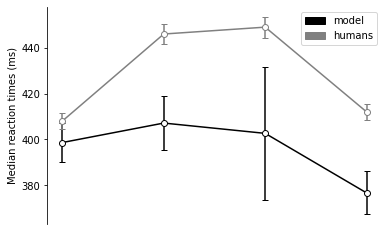

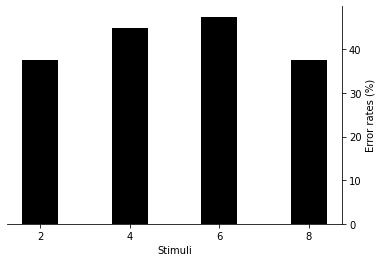

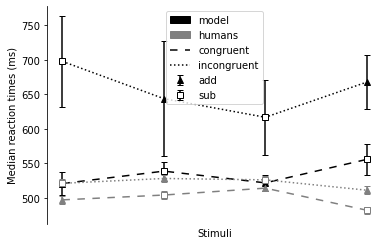

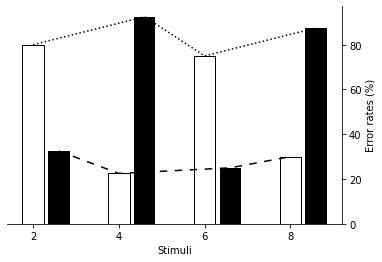

params: [0.2944273971744243, 18.563330162854065, 0.12364336574817465, 2635, 0.1988937186163001, 0.9667409857936884, 5, 22.835938723416852, 0.01253263841620225]
Simulating...
	 seed 1/20
	 seed 2/20
	 seed 3/20
	 seed 4/20
	 seed 5/20
	 seed 6/20
	 seed 7/20
	 seed 8/20
	 seed 9/20
	 seed 10/20
	 seed 11/20
running run_seed11_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=18, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=19, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=20, similarity=0.12)
  len(self._key2idx), best_sim))


No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 11
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c6568ed0>
xp = <experiments.Xp1 object at 0x7ff4d621e690>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d7e3e8d0>
	 seed 12/20
running run_seed12_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=16, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=19, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=20, similarity=0.12)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 12
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d52ce190>
xp = <experiments.Xp1 object at 0x7ff4da01af90>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c47fc310>
	 seed 13/20
running run_seed13_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=19, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 13
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c56f4050>
xp = <experiments.Xp1 object at 0x7ff4c47e4f50>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c70e2490>
	 seed 14/20
running run_seed14_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 14
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d5d009d0>
xp = <experiments.Xp1 object at 0x7ff4c37ebb50>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4780c1210>
	 seed 15/20
running run_seed15_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=17, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 15
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c2caf150>
xp = <experiments.Xp1 object at 0x7ff4c47e4b90>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d557b410>
	 seed 16/20
running run_seed16_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=18, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 16
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d55756d0>
xp = <experiments.Xp1 object at 0x7ff478c54550>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff484154d90>
	 seed 17/20
running run_seed17_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=20, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 17
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d56f8510>
xp = <experiments.Xp1 object at 0x7ff4798788d0>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47842a910>
	 seed 18/20
running run_seed18_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 18
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c59f8290>
xp = <experiments.Xp1 object at 0x7ff4da5e8dd0>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c65f60d0>
	 seed 19/20
running run_seed19_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=18, similarity=0.10)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=19, similarity=0.12)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 19
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c2bfb390>
xp = <experiments.Xp1 object at 0x7ff4d557a9d0>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d62347d0>
	 seed 20/20
running run_seed20_crosstalk0.2944273971744243_sevid18.563330162854065_nsamples2635_combscale0.1988937186163001_procfb0.9667409857936884_D80_gwscale22.835938723416852_prevsyn0.01253263841620225


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=80, M=16, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 20
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.1988937186163001
s_crosstalk = 0.2944273971744243
s_evidence = 18.563330162854065
n_samples = 2635
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d5f98210>
xp = <experiments.Xp1 object at 0x7ff4798a9690>
proc_feedback = 0.9667409857936884
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.01253263841620225
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 22.835938723416852
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d7e41e10>
rmse : 73.3185570965985


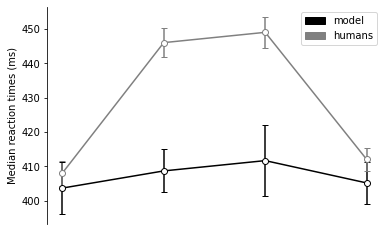

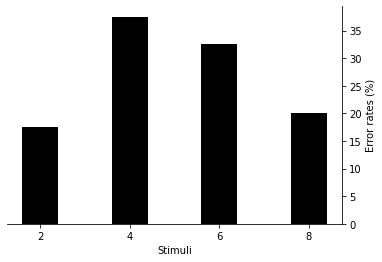

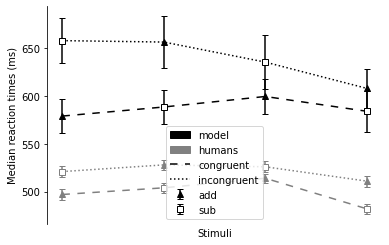

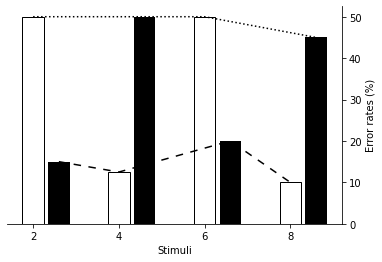

params: [0.8673512747099721, 17.42630133484004, 0.08737077088009122, 7493, 0.5149702556805613, 0.5719394835567857, 4, 5.279414941493777, 0.011568166413305485]
Simulating...
	 seed 1/20
	 seed 2/20
	 seed 3/20
	 seed 4/20
	 seed 5/20
	 seed 6/20
	 seed 7/20
	 seed 8/20
	 seed 9/20
	 seed 10/20
	 seed 11/20
running run_seed11_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.12)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=19, similarity=0.13)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=20, similarity=0.13)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 11
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d628b390>
xp = <experiments.Xp1 object at 0x7ff4d6295650>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c6858750>
	 seed 12/20
running run_seed12_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity=0.10)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=18, similarity=0.13)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=19, similarity=0.12)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 12
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c2a92490>
xp = <experiments.Xp1 object at 0x7ff478667b90>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4872e5850>
	 seed 13/20
running run_seed13_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 13
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c25e9a90>
xp = <experiments.Xp1 object at 0x7ff484adae10>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff50418d550>
	 seed 14/20
running run_seed14_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.13)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=19, similarity=0.14)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=20, similarity=0.12)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 14
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c49dd9d0>
xp = <experiments.Xp1 object at 0x7ff485a5afd0>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff481513b50>
	 seed 15/20
running run_seed15_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.10)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=20, similarity=0.14)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 15
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff47adae9d0>
xp = <experiments.Xp1 object at 0x7ff4c63b6890>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c35fcb90>
	 seed 16/20
running run_seed16_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=18, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 16
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d7be28d0>
xp = <experiments.Xp1 object at 0x7ff4c344ef90>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47ea06690>
	 seed 17/20
running run_seed17_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.10)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=18, similarity=0.10)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=19, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 17
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff47ad9e610>
xp = <experiments.Xp1 object at 0x7ff4d557a0d0>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47eaec950>
	 seed 18/20
running run_seed18_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 18
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c639ffd0>
xp = <experiments.Xp1 object at 0x7ff484b1d790>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c65007d0>
	 seed 19/20
running run_seed19_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 19
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff485a65090>
xp = <experiments.Xp1 object at 0x7ff485815d10>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c25eb990>
	 seed 20/20
running run_seed20_crosstalk0.8673512747099721_sevid17.42630133484004_nsamples7493_combscale0.5149702556805613_procfb0.5719394835567857_D64_gwscale5.279414941493777_prevsyn0.011568166413305485


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=18, similarity=0.12)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 20
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5149702556805613
s_crosstalk = 0.8673512747099721
s_evidence = 17.42630133484004
n_samples = 7493
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d4605d50>
xp = <experiments.Xp1 object at 0x7ff485a65550>
proc_feedback = 0.5719394835567857
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011568166413305485
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 5.279414941493777
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d61163d0>
rmse : 35.661294124841405


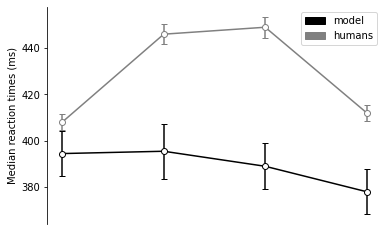

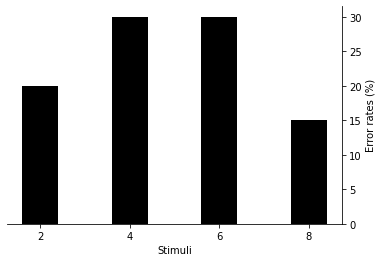

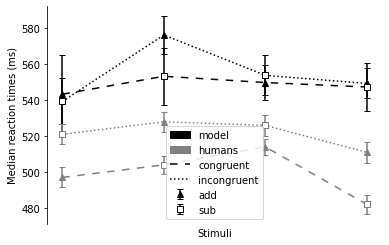

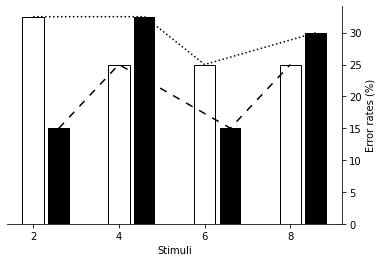

params: [0.5141590329358398, 7.484787786686427, 0.1195190334302882, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253]
Simulating...
	 seed 1/20
	 seed 2/20
	 seed 3/20
	 seed 4/20
	 seed 5/20
	 seed 6/20
	 seed 7/20
	 seed 8/20
	 seed 9/20
	 seed 10/20
	 seed 11/20
running run_seed11_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 11
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4d5e2ddd0>
xp = <experiments.Xp1 object at 0x7ff4c547dbd0>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d5755590>
	 seed 12/20
running run_seed12_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 12
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c31b0a50>
xp = <experiments.Xp1 object at 0x7ff4c5ffb3d0>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47969d290>
	 seed 13/20
running run_seed13_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 13
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4796a8dd0>
xp = <experiments.Xp1 object at 0x7ff4c2a0b350>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff484cf6150>
	 seed 14/20
running run_seed14_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 14
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff483aca6d0>
xp = <experiments.Xp1 object at 0x7ff4d5744e50>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff484265790>
	 seed 15/20
running run_seed15_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 15
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c47cff90>
xp = <experiments.Xp1 object at 0x7ff4783f1710>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4d42ce6d0>
	 seed 16/20
running run_seed16_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 16
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff483af8690>
xp = <experiments.Xp1 object at 0x7ff484258990>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47d9d8350>
	 seed 17/20
running run_seed17_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 17
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff47eb72f50>
xp = <experiments.Xp1 object at 0x7ff4d5871dd0>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47dee1610>
	 seed 18/20
running run_seed18_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=112, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 18
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff47dee1410>
xp = <experiments.Xp1 object at 0x7ff4c4ca0790>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4783e8450>
	 seed 19/20
running run_seed19_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 19
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff4c2e3e850>
xp = <experiments.Xp1 object at 0x7ff47ca47090>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff4c7647f90>
	 seed 20/20
running run_seed20_crosstalk0.5141590329358398_sevid7.484787786686427_nsamples7665_combscale0.5540877322244593_procfb0.9073665908931585_D112_gwscale4.036586424613745_prevsyn0.010791654845471253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 20
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5540877322244593
s_crosstalk = 0.5141590329358398
s_evidence = 7.484787786686427
n_samples = 7665
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7ff47f7040d0>
xp = <experiments.Xp1 object at 0x7ff47c4d7950>
proc_feedback = 0.9073665908931585
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.010791654845471253
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.036586424613745
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7ff47c793a50>
rmse : 82.12889451181603


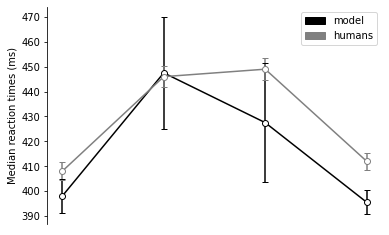

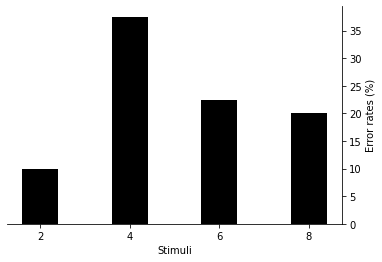

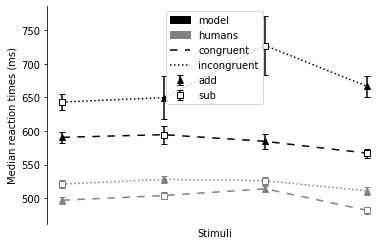

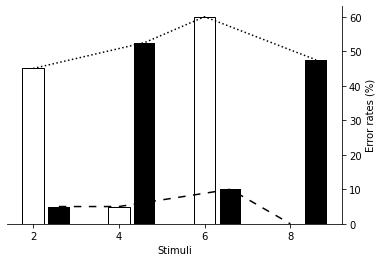

In [40]:
candidates = [
#     [0.8463109166860173, 9.699102753984128, 0.10490963191457431, 4490, 0.30661949235684305, 0.7672069544735085, 9, 14.258939431622663, 0.009752574209324755],
#     [0.2730499742167474, 5.888648019523452, 0.13410560801378912, 5971, 0.704488687679921, 0.7058939394845265, 4, 9.399259575828562, 0.004558162438549226],
    [0.6477493997733477, 10.30908633197453, 0.15264661054302442, 3630, 0.777509517858044, 0.9406709148170056, 2, 15.445163019218862, 0.0033282562052117833],
#     [0.5139976329388788, 18.414177174564905, 0.05056535015925409+.05, 6645, 0.19536987556006435, 0.9280077706286105, 10, 9.018652132500627, 0.008712265216087306],
#     [0.20165971807052613, 6.02436589212857, 0.052368294221117676, 3671, 0.952773318599222, 0.8549823885290033, 9, 19.303761307498952, 0.002190532260918006],
#     [0.0525024818369212, 10.51731878872845, 0.17483188542668088-.03, 6763, 0.15921329528407605, 0.9605323324085461, 4, 11.643657838449212, 0.0039650138272247695],
#     [0.8733180849349123, 13.312279867708797, 0.12402602637560184, 1377, 0.7444200784558392, 0.7606842768863016, 8, 10.241912805134255, 0.0180966165099226],
    [0.2944273971744243, 18.563330162854065, 0.17364336574817466-.05, 2635, 0.1988937186163001, 0.9667409857936884, 5, 22.835938723416852, 0.01253263841620225],
    [0.8673512747099721, 17.42630133484004, 0.08737077088009122, 7493, 0.5149702556805613, 0.5719394835567857, 4, 5.279414941493777, 0.011568166413305485],
#     [0.29070376432314776, 19.354436427701124-1, 0.11779345826490306, 1618, 0.3894202579288364, 0.9494757711007107, 9, 6.085043480213131, 0.005625260175824355],
    [0.5141590329358398, 7.484787786686427, 0.1695190334302882-.05, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253],
#     [0.6648360665714368, 18.479692260914195, 0.07073469694820798+.05, 8269, 0.6855980901062497, 0.6222927983911885, 4, 8.202553178710245, 0.00464703780502297],
#     [0.9233831056468913, 8.662400395267506, 0.12977651996482037, 119, 0.5079431142449035, 0.7161557738927364, 6, 24.184459527068782, 0.01764209573510557]
]

rmse_res = gp_minimize(create_evaluation_function(plot=True, n_seeds=20), 
    dimensions=[
        Real(0, 1, name="crosstalk"), # crosstalk
        Real(5, 20, name="evidence strength"), # evidence strength
        Real(0, .2, name="senso"), # sensory delay
        Integer(100, 10000, name="number of samples"), # number of samples
        Real(.1, 1, name="scale combined"), # n_neurons_scale_combined
        Real(.5, 1, name="processor feedback"), # processor feedback
        Integer(2, 10, name="dimensions"), # dimensions (*16)
        Real(1, 30, name="GW scale"), # GW scale
        Real(.002, .02, name="PREV feedback synapse"), # PREV feedback synapse
    ],
#     x0=[
#         .15, # crosstalk
#         15, # evidence strength
#         .1, # sensory delay
#         N_SAMPLES,
#         N_NEURONS_SCALE_COMBINED,
#         PROC_FDBCK,
#         int(D/16),
#         GW_SCALE,
#         .01 # prev fb syn
#     ],
    n_calls=len(candidates),
    random_state=STARTING_SEED,
    x0=candidates,
    n_random_starts=0,
               
)

params: [0.5141590329358398, 7.484787786686427, 0.1295190334302882, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253]
Simulating...
	 seed 1/31
	 seed 2/31
	 seed 3/31
	 seed 4/31
	 seed 5/31
	 seed 6/31
	 seed 7/31
	 seed 8/31
	 seed 9/31
	 seed 10/31
	 seed 11/31
	 seed 12/31
	 seed 13/31
	 seed 14/31
	 seed 15/31
	 seed 16/31
	 seed 17/31
	 seed 18/31
	 seed 19/31
	 seed 20/31
	 seed 21/31
	 seed 22/31
	 seed 23/31
	 seed 24/31
	 seed 25/31
	 seed 26/31
	 seed 27/31
	 seed 28/31
	 seed 29/31
	 seed 30/31
	 seed 31/31
compare error rates: True
rmse : 86.26421423437563


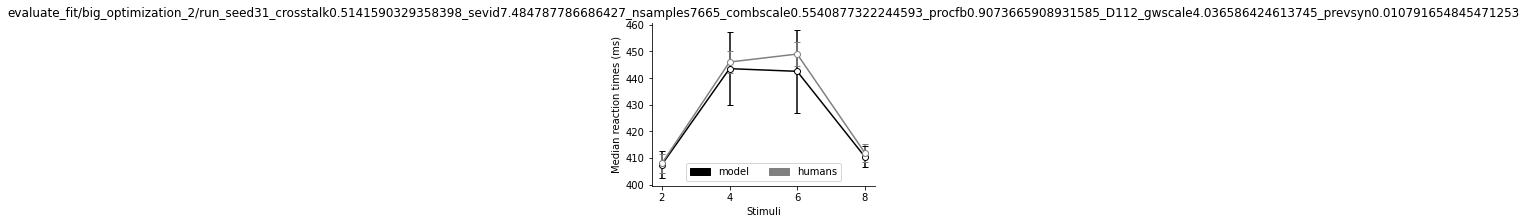

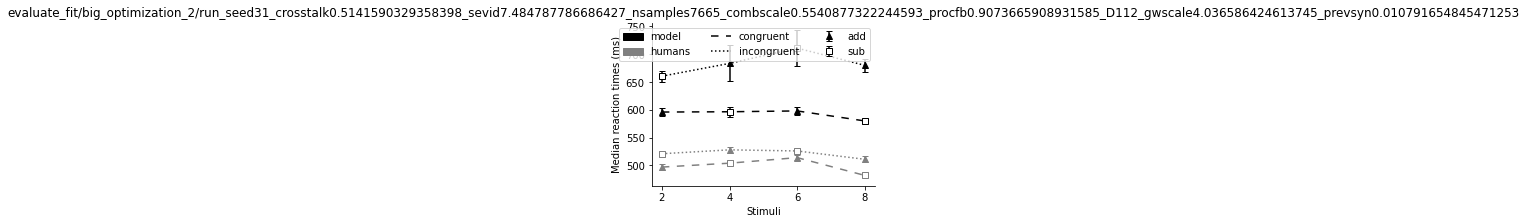

ValueError: array must not contain infs or NaNs

In [6]:
candidates = [
#     [0.8463109166860173, 9.699102753984128, 0.10490963191457431, 4490, 0.30661949235684305, 0.7672069544735085, 9, 14.258939431622663, 0.009752574209324755],
#     [0.2730499742167474, 5.888648019523452, 0.13410560801378912, 5971, 0.704488687679921, 0.7058939394845265, 4, 9.399259575828562, 0.004558162438549226],
#     [0.6477493997733477, 10.30908633197453, 0.15264661054302442, 3630, 0.777509517858044, 0.9406709148170056, 2, 15.445163019218862, 0.0033282562052117833],
#     [0.5139976329388788, 18.414177174564905, 0.05056535015925409+.05, 6645, 0.19536987556006435, 0.9280077706286105, 10, 9.018652132500627, 0.008712265216087306],
#     [0.20165971807052613, 6.02436589212857, 0.052368294221117676, 3671, 0.952773318599222, 0.8549823885290033, 9, 19.303761307498952, 0.002190532260918006],
#     [0.0525024818369212, 10.51731878872845, 0.17483188542668088-.03, 6763, 0.15921329528407605, 0.9605323324085461, 4, 11.643657838449212, 0.0039650138272247695],
#     [0.8733180849349123, 13.312279867708797, 0.12402602637560184, 1377, 0.7444200784558392, 0.7606842768863016, 8, 10.241912805134255, 0.0180966165099226],
#     [0.2944273971744243, 18.563330162854065, 0.17364336574817466-.05, 2635, 0.1988937186163001, 0.9667409857936884, 5, 22.835938723416852, 0.01253263841620225],
#     [0.8673512747099721, 17.42630133484004, 0.08737077088009122, 7493, 0.5149702556805613, 0.5719394835567857, 4, 5.279414941493777, 0.011568166413305485],
#     [0.29070376432314776, 19.354436427701124-1, 0.11779345826490306, 1618, 0.3894202579288364, 0.9494757711007107, 9, 6.085043480213131, 0.005625260175824355],
    [0.5141590329358398, 7.484787786686427, 0.1695190334302882-.04, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253],
#     [0.6648360665714368, 18.479692260914195, 0.07073469694820798+.05, 8269, 0.6855980901062497, 0.6222927983911885, 4, 8.202553178710245, 0.00464703780502297],
#     [0.9233831056468913, 8.662400395267506, 0.12977651996482037, 119, 0.5079431142449035, 0.7161557738927364, 6, 24.184459527068782, 0.01764209573510557]
]

rmse_res = gp_minimize(create_evaluation_function(plot=True, n_seeds=31), 
    dimensions=[
        Real(0, 1, name="crosstalk"), # crosstalk
        Real(5, 20, name="evidence strength"), # evidence strength
        Real(0, .2, name="senso"), # sensory delay
        Integer(100, 10000, name="number of samples"), # number of samples
        Real(.1, 1, name="scale combined"), # n_neurons_scale_combined
        Real(.5, 1, name="processor feedback"), # processor feedback
        Integer(2, 10, name="dimensions"), # dimensions (*16)
        Real(1, 30, name="GW scale"), # GW scale
        Real(.002, .02, name="PREV feedback synapse"), # PREV feedback synapse
    ],
#     x0=[
#         .15, # crosstalk
#         15, # evidence strength
#         .1, # sensory delay
#         N_SAMPLES,
#         N_NEURONS_SCALE_COMBINED,
#         PROC_FDBCK,
#         int(D/16),
#         GW_SCALE,
#         .01 # prev fb syn
#     ],
    n_calls=len(candidates),
    random_state=STARTING_SEED,
    x0=candidates,
    n_random_starts=0,
               
)

params: [0.5141590329358398, 7.484787786686427, 0.1295190334302882, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
compare error rates: True
rmse : 75.74516561897043


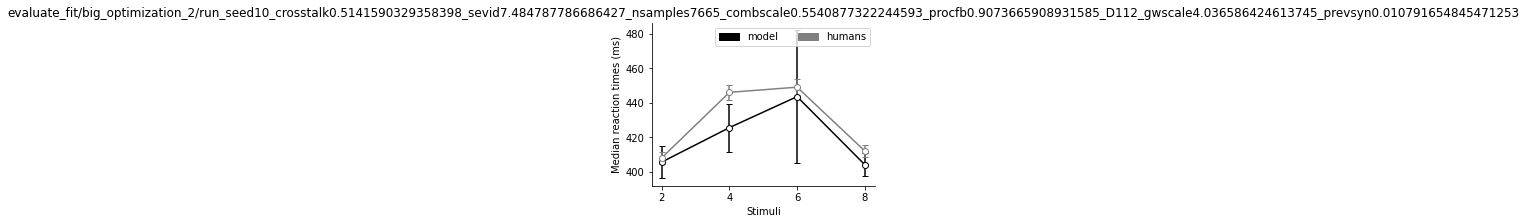

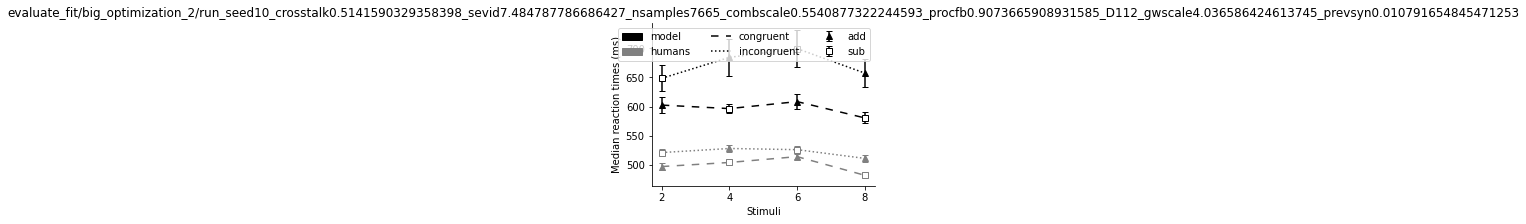

params: [0.6988739243755475, 7.932557359338659, 0.08896871135505498, 7999, 0.5236088976951976, 38.18807547492087, 7, 4.08487301840174, 0.014355390708060318]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
compare error rates: True


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1060.0773850280043


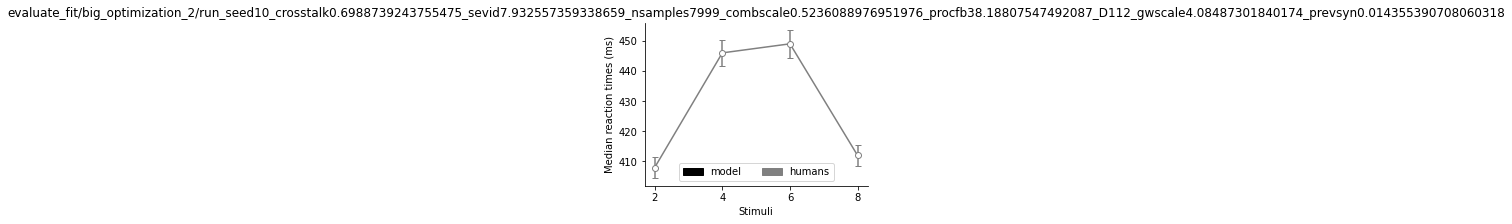

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

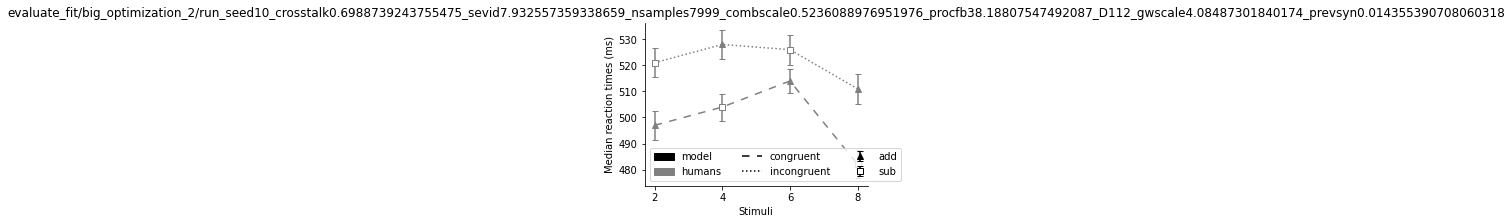

params: [0.6385243666744069, 7.313273516932275, 0.116718371170101, 7443, 0.5229577213729826, 51.165069527361666, 8, 3.978602403993494, 0.009306985671847085]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
compare error rates: True


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1060.0773850280043


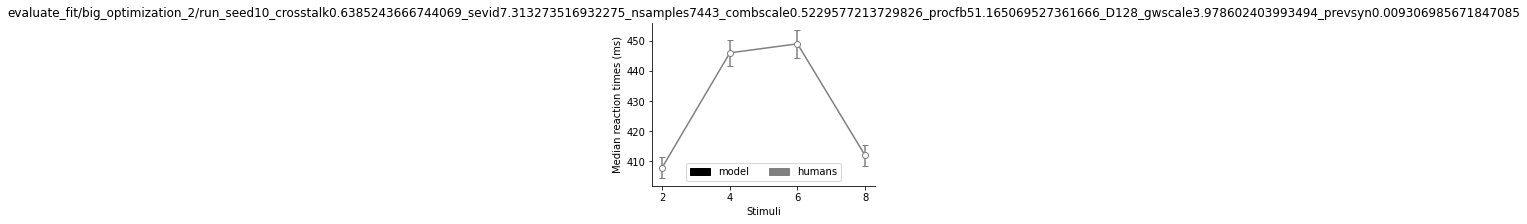

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

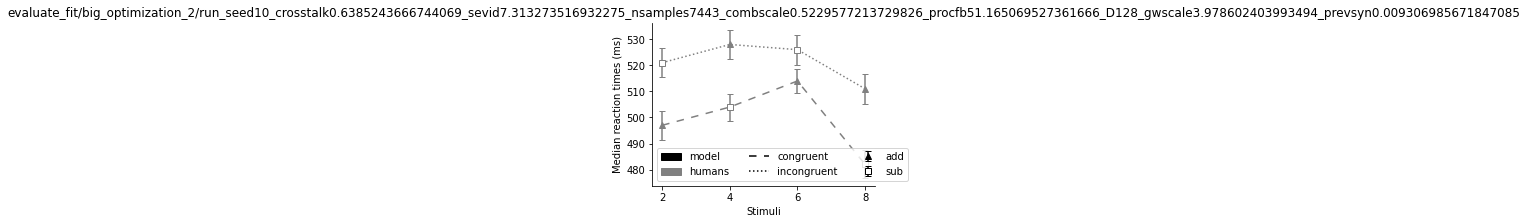

params: [0.6756511157694504, 7.778389236336533, 0.1301179361177855, 7803, 0.5092800808640738, 49.63406248287887, 8, 4.164573453683571, 0.013296033593941839]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
compare error rates: True


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1060.0773850280043


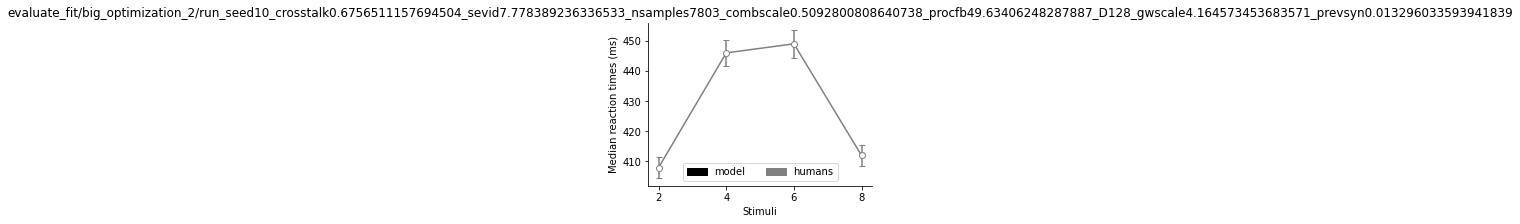

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-c79fe079a134>", line 43, in <module>
    n_random_starts=10,
  File "/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/skopt/optimizer/gp.py", line 271, in gp_minimize
    callback=callback, n_jobs=n_jobs, model_queue_size=model_queue_size)
  File "/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/skopt/optimizer/base.py", line 272, in base_minimize
    next_y = func(next_x)
  File "<ipython-input-3-688d992047c2>", line 67, in evaluation_function
    data.plot_fig2_chained(plot_humans=True, save_file=data_dir+'/'+data_filename, errorates=False)
  File "../data.py", line 198, in plot_fig2_chained
    plt.show()
  File "/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/matplotlib/pyplot.py", line 272, in show
    return _s

KeyboardInterrupt: 

In [5]:
candidates = [
#     [0.8463109166860173, 9.699102753984128, 0.10490963191457431, 4490, 0.30661949235684305, 0.7672069544735085, 9, 14.258939431622663, 0.009752574209324755],
#     [0.2730499742167474, 5.888648019523452, 0.13410560801378912, 5971, 0.704488687679921, 0.7058939394845265, 4, 9.399259575828562, 0.004558162438549226],
#     [0.6477493997733477, 10.30908633197453, 0.15264661054302442, 3630, 0.777509517858044, 0.9406709148170056, 2, 15.445163019218862, 0.0033282562052117833],
#     [0.5139976329388788, 18.414177174564905, 0.05056535015925409+.05, 6645, 0.19536987556006435, 0.9280077706286105, 10, 9.018652132500627, 0.008712265216087306],
#     [0.20165971807052613, 6.02436589212857, 0.052368294221117676, 3671, 0.952773318599222, 0.8549823885290033, 9, 19.303761307498952, 0.002190532260918006],
#     [0.0525024818369212, 10.51731878872845, 0.17483188542668088-.03, 6763, 0.15921329528407605, 0.9605323324085461, 4, 11.643657838449212, 0.0039650138272247695],
#     [0.8733180849349123, 13.312279867708797, 0.12402602637560184, 1377, 0.7444200784558392, 0.7606842768863016, 8, 10.241912805134255, 0.0180966165099226],
#     [0.2944273971744243, 18.563330162854065, 0.17364336574817466-.05, 2635, 0.1988937186163001, 0.9667409857936884, 5, 22.835938723416852, 0.01253263841620225],
#     [0.8673512747099721, 17.42630133484004, 0.08737077088009122, 7493, 0.5149702556805613, 0.5719394835567857, 4, 5.279414941493777, 0.011568166413305485],
#     [0.29070376432314776, 19.354436427701124-1, 0.11779345826490306, 1618, 0.3894202579288364, 0.9494757711007107, 9, 6.085043480213131, 0.005625260175824355],
    [0.5141590329358398, 7.484787786686427, 0.1695190334302882-.05, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253],
#     [0.6648360665714368, 18.479692260914195, 0.07073469694820798+.05, 8269, 0.6855980901062497, 0.6222927983911885, 4, 8.202553178710245, 0.00464703780502297],
#     [0.9233831056468913, 8.662400395267506, 0.12977651996482037, 119, 0.5079431142449035, 0.7161557738927364, 6, 24.184459527068782, 0.01764209573510557]
]

rmse_res = gp_minimize(create_evaluation_function(plot=True, n_seeds=10), 
    dimensions=[
        Real(0.3, .7, name="crosstalk"), # crosstalk
        Real(7, 8, name="evidence strength"), # evidence strength
        Real(.08, .15, name="senso"), # sensory delay
        Integer(7000, 8000, name="number of samples"), # number of samples
        Real(.5, .6, name="scale combined"), # n_neurons_scale_combined
        Real(.85, 95, name="processor feedback"), # processor feedback
        Integer(6, 8, name="dimensions"), # dimensions (*16)
        Real(3.75, 4.25, name="GW scale"), # GW scale
        Real(0.005, 0.015, name="PREV feedback synapse"), # PREV feedback synapse
    ],
#     x0=[
#         .15, # crosstalk
#         15, # evidence strength
#         .1, # sensory delay
#         N_SAMPLES,
#         N_NEURONS_SCALE_COMBINED,
#         PROC_FDBCK,
#         int(D/16),
#         GW_SCALE,
#         .01 # prev fb syn
#     ],
    n_calls=100,
    random_state=STARTING_SEED,
    x0=candidates[0],
    n_random_starts=10,
               
)

params: [0.5141590329358398, 7.484787786686427, 0.1195190334302882, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253]
Simulating...
	 seed 1/10
	 seed 2/10
	 seed 3/10
	 seed 4/10
	 seed 5/10
	 seed 6/10
	 seed 7/10
	 seed 8/10
	 seed 9/10
	 seed 10/10
compare error rates: False
rmse : 96.81563740665572


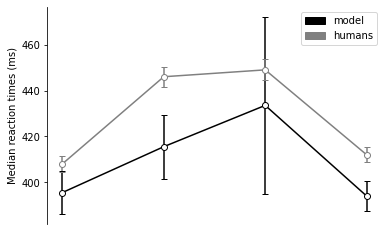

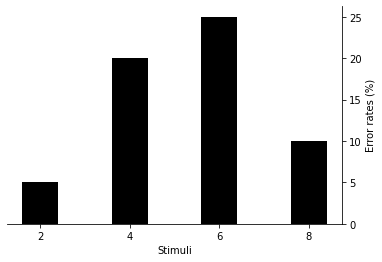

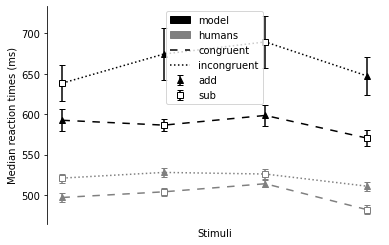

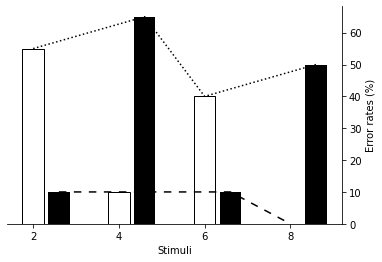

params: [0.6988739243755475, 9.730229437354636, 0.08896871135505498, 7999, 0.5236088976951976, 38.18807547492087, 7, 4.08487301840174, 0.014355390708060318]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae395f50>
xp = <experiments.Xp1 object at 0x7fc95c51fdd0>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9af391350>
	 seed 2/10
running run_seed2_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc998a10990>
xp = <experiments.Xp1 object at 0x7fc9ae95ccd0>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc96440fa90>
	 seed 3/10
running run_seed3_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae83fc50>
xp = <experiments.Xp1 object at 0x7fc9643f6e50>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ad955450>
	 seed 4/10
running run_seed4_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae60ea90>
xp = <experiments.Xp1 object at 0x7fc9ae62f5d0>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9af0c5990>
	 seed 5/10
running run_seed5_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae2b4c90>
xp = <experiments.Xp1 object at 0x7fc9aef39b10>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc944967890>
	 seed 6/10
running run_seed6_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95758e6d0>
xp = <experiments.Xp1 object at 0x7fc9ae29aa90>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95c61a210>
	 seed 7/10
running run_seed7_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=112, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9afb08e90>
xp = <experiments.Xp1 object at 0x7fc94497eed0>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93dcfc410>
	 seed 8/10
running run_seed8_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d277150>
xp = <experiments.Xp1 object at 0x7fc9ad9340d0>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95f6d5110>
	 seed 9/10
running run_seed9_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc92a72cc50>
xp = <experiments.Xp1 object at 0x7fc9442efdd0>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9aead1210>
	 seed 10/10
running run_seed10_crosstalk0.6988739243755475_sevid9.730229437354636_nsamples7999_combscale0.5236088976951976_procfb38.18807547492087_D112_gwscale4.08487301840174_prevsyn0.014355390708060318


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5236088976951976
s_crosstalk = 0.6988739243755475
s_evidence = 9.730229437354636
n_samples = 7999
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d932690>
xp = <experiments.Xp1 object at 0x7fc93a58e950>
proc_feedback = 38.18807547492087
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.014355390708060318
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.08487301840174
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc928999650>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


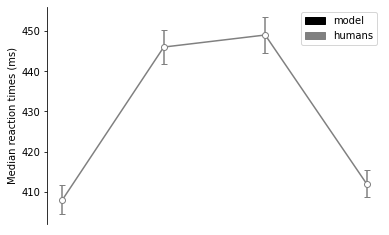

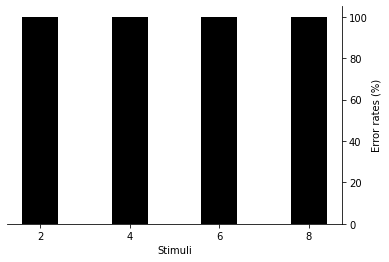

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

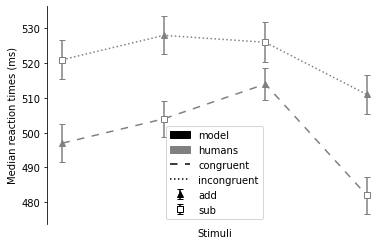

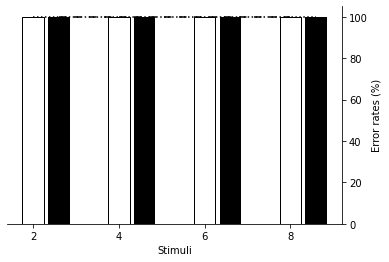

params: [0.6385243666744069, 7.2530940677291005, 0.116718371170101, 7443, 0.5229577213729826, 51.165069527361666, 8, 3.978602403993494, 0.009306985671847085]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9a3d28250>
xp = <experiments.Xp1 object at 0x7fc945186e90>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95f6eccd0>
	 seed 2/10
running run_seed2_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9bc061e90>
xp = <experiments.Xp1 object at 0x7fc9bee14610>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc929a5c5d0>
	 seed 3/10
running run_seed3_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc96a876c50>
xp = <experiments.Xp1 object at 0x7fc9c087fed0>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9af0de510>
	 seed 4/10
running run_seed4_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc954fc3cd0>
xp = <experiments.Xp1 object at 0x7fc9984b8210>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95c692d90>
	 seed 5/10
running run_seed5_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d0730d0>
xp = <experiments.Xp1 object at 0x7fc9984b8590>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d046710>
	 seed 6/10
running run_seed6_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae7fb650>
xp = <experiments.Xp1 object at 0x7fc956c19110>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95c622ed0>
	 seed 7/10
running run_seed7_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93c6a5c10>
xp = <experiments.Xp1 object at 0x7fc9bc06fb10>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93c2e8f90>
	 seed 8/10
running run_seed8_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo/cache.py:447: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  "Decoder cache index could not acquire lock. "


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9992dd8d0>
xp = <experiments.Xp1 object at 0x7fc9399bccd0>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95c2d9290>
	 seed 9/10
running run_seed9_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9306e1a90>
xp = <experiments.Xp1 object at 0x7fc939f8f050>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d53d490>
	 seed 10/10
running run_seed10_crosstalk0.6385243666744069_sevid7.2530940677291005_nsamples7443_combscale0.5229577213729826_procfb51.165069527361666_D128_gwscale3.978602403993494_prevsyn0.009306985671847085


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5229577213729826
s_crosstalk = 0.6385243666744069
s_evidence = 7.2530940677291005
n_samples = 7443
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc939ff1510>
xp = <experiments.Xp1 object at 0x7fc92bf3fd90>
proc_feedback = 51.165069527361666
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009306985671847085
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.978602403993494
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc939513910>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


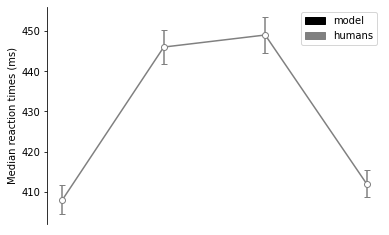

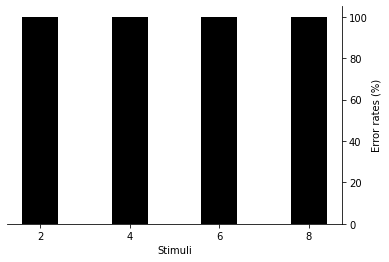

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

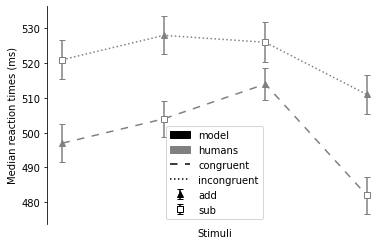

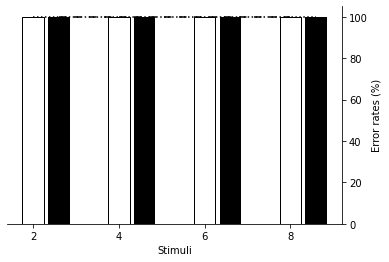

params: [0.6756511157694504, 9.113556945346135, 0.1301179361177855, 7803, 0.5092800808640738, 49.63406248287887, 8, 4.164573453683571, 0.013296033593941839]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93af15650>
xp = <experiments.Xp1 object at 0x7fc93cbb1410>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc965eb3ed0>
	 seed 2/10
running run_seed2_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc955143650>
xp = <experiments.Xp1 object at 0x7fc9ade7b7d0>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d020e10>
	 seed 3/10
running run_seed3_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93ba5ab50>
xp = <experiments.Xp1 object at 0x7fc9297acb90>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93ba5a110>
	 seed 4/10
running run_seed4_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d000a10>
xp = <experiments.Xp1 object at 0x7fc93bda7890>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9aeadc210>
	 seed 5/10
running run_seed5_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9adaa7290>
xp = <experiments.Xp1 object at 0x7fc9432d4a90>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d924b10>
	 seed 6/10
running run_seed6_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d925dd0>
xp = <experiments.Xp1 object at 0x7fc9afe07890>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93a955390>
	 seed 7/10
running run_seed7_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ad485990>
xp = <experiments.Xp1 object at 0x7fc95ca40d50>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ad717750>
	 seed 8/10
running run_seed8_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9299d4f50>
xp = <experiments.Xp1 object at 0x7fc954d05f90>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93b490b50>
	 seed 9/10
running run_seed9_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93a907ed0>
xp = <experiments.Xp1 object at 0x7fc93d9b8f50>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93a923850>
	 seed 10/10
running run_seed10_crosstalk0.6756511157694504_sevid9.113556945346135_nsamples7803_combscale0.5092800808640738_procfb49.63406248287887_D128_gwscale4.164573453683571_prevsyn0.013296033593941839


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5092800808640738
s_crosstalk = 0.6756511157694504
s_evidence = 9.113556945346135
n_samples = 7803
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d2b3f90>
xp = <experiments.Xp1 object at 0x7fc93cfd3bd0>
proc_feedback = 49.63406248287887
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.013296033593941839
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.164573453683571
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9984bc7d0>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


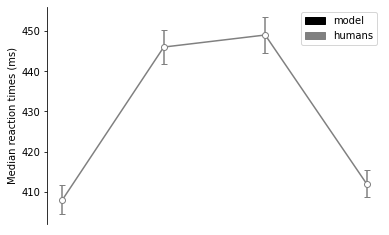

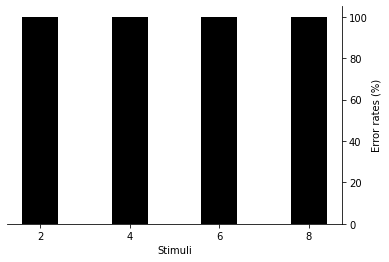

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

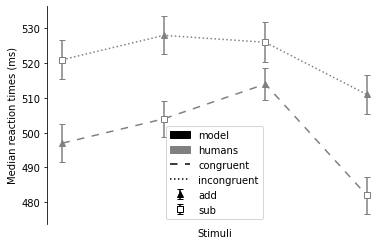

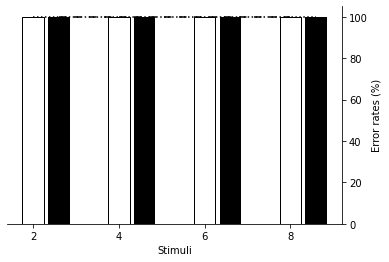

params: [0.4092199896866989, 6.236972805206254, 0.1269369628048262, 7593, 0.5671654097422134, 39.619828804936354, 6, 3.8948148202729063, 0.00642120135474957]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95c879710>
xp = <experiments.Xp1 object at 0x7fc9be3b5110>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9305e2850>
	 seed 2/10
running run_seed2_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae7c9dd0>
xp = <experiments.Xp1 object at 0x7fc928983fd0>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9530c8c50>
	 seed 3/10
running run_seed3_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=20, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc92b791e10>
xp = <experiments.Xp1 object at 0x7fc939c23850>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc928b5ee50>
	 seed 4/10
running run_seed4_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=19, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc928b72790>
xp = <experiments.Xp1 object at 0x7fc93c727ed0>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93cf3a950>
	 seed 5/10
running run_seed5_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9afb76210>
xp = <experiments.Xp1 object at 0x7fc999744250>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9441cb990>
	 seed 6/10
running run_seed6_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc943eb4910>
xp = <experiments.Xp1 object at 0x7fc999744b90>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93cd517d0>
	 seed 7/10
running run_seed7_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93bf7e390>
xp = <experiments.Xp1 object at 0x7fc93bed5790>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9571aadd0>
	 seed 8/10
running run_seed8_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9adcc30d0>
xp = <experiments.Xp1 object at 0x7fc9984b42d0>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc92913e910>
	 seed 9/10
running run_seed9_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc956368450>
xp = <experiments.Xp1 object at 0x7fc95d53cad0>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc96a5d81d0>
	 seed 10/10
running run_seed10_crosstalk0.4092199896866989_sevid6.236972805206254_nsamples7593_combscale0.5671654097422134_procfb39.619828804936354_D96_gwscale3.8948148202729063_prevsyn0.00642120135474957


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=19, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5671654097422134
s_crosstalk = 0.4092199896866989
s_evidence = 6.236972805206254
n_samples = 7593
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae6481d0>
xp = <experiments.Xp1 object at 0x7fc9ae659890>
proc_feedback = 39.619828804936354
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00642120135474957
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8948148202729063
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95e0f7c90>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


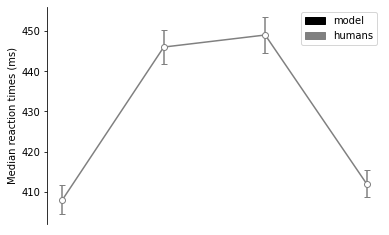

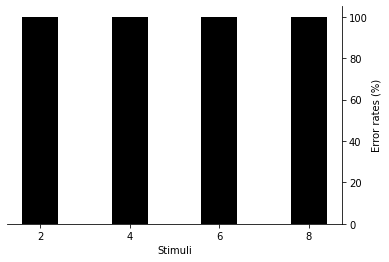

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

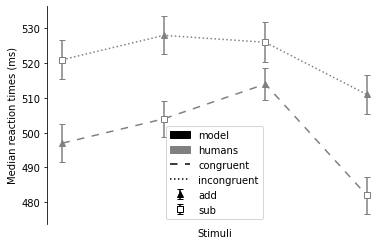

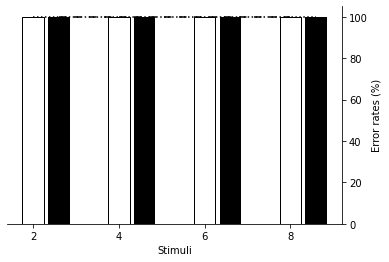

params: [0.6133257890779545, 7.650155366012105, 0.08239199178300874, 7624, 0.5660635730238003, 28.95333200099917, 7, 3.8610622737676876, 0.005733641717425996]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc929836690>
xp = <experiments.Xp1 object at 0x7fc93c83fbd0>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae76de10>
	 seed 2/10
running run_seed2_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ad73b4d0>
xp = <experiments.Xp1 object at 0x7fc9a3ff3510>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae830690>
	 seed 3/10
running run_seed3_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9adb49c50>
xp = <experiments.Xp1 object at 0x7fc9530607d0>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae830550>
	 seed 4/10
running run_seed4_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc939a71810>
xp = <experiments.Xp1 object at 0x7fc93bb5c290>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae740710>
	 seed 5/10
running run_seed5_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93cad25d0>
xp = <experiments.Xp1 object at 0x7fc9ad3c92d0>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95f0c7e50>
	 seed 6/10
running run_seed6_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95c4bdf50>
xp = <experiments.Xp1 object at 0x7fc93b20a190>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95d842c50>
	 seed 7/10
running run_seed7_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=112, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc930d24410>
xp = <experiments.Xp1 object at 0x7fc9ae54cf90>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc998468bd0>
	 seed 8/10
running run_seed8_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d0ead90>
xp = <experiments.Xp1 object at 0x7fc95f0e6c90>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95db29ed0>
	 seed 9/10
running run_seed9_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc928ac8150>
xp = <experiments.Xp1 object at 0x7fc93b5c76d0>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93cdee490>
	 seed 10/10
running run_seed10_crosstalk0.6133257890779545_sevid7.650155366012105_nsamples7624_combscale0.5660635730238003_procfb28.95333200099917_D112_gwscale3.8610622737676876_prevsyn0.005733641717425996


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5660635730238003
s_crosstalk = 0.6133257890779545
s_evidence = 7.650155366012105
n_samples = 7624
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95c677cd0>
xp = <experiments.Xp1 object at 0x7fc929a7dcd0>
proc_feedback = 28.95333200099917
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005733641717425996
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8610622737676876
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93a590890>
compare error rates: False
rmse : 1496.2751247618935


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


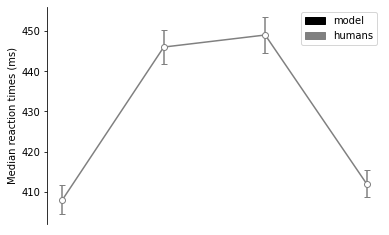

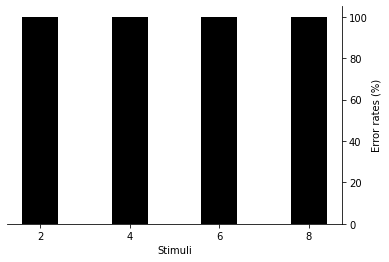

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

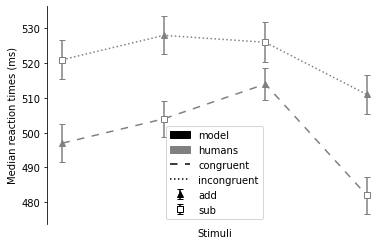

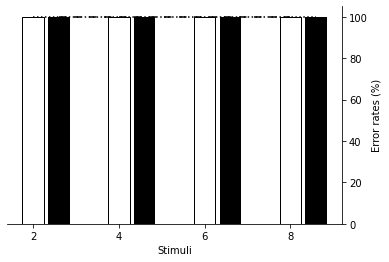

params: [0.4876954105752572, 6.384689041781847, 0.14323591165352073, 7119, 0.5524799376870445, 8.723105878102519, 8, 4.205224190896551, 0.007989301122097161]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc952edd650>
xp = <experiments.Xp1 object at 0x7fc93bb095d0>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9288db1d0>
	 seed 2/10
running run_seed2_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93ba7bf50>
xp = <experiments.Xp1 object at 0x7fc95e6d9810>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9a3f125d0>
	 seed 3/10
running run_seed3_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95dfa4650>
xp = <experiments.Xp1 object at 0x7fc93ba80fd0>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc944ae9810>
	 seed 4/10
running run_seed4_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93c2d0e90>
xp = <experiments.Xp1 object at 0x7fc954f8ee90>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ad53ed10>
	 seed 5/10
running run_seed5_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc956351b50>
xp = <experiments.Xp1 object at 0x7fc9536f5e50>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9bdd03250>
	 seed 6/10
running run_seed6_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc939c0e2d0>
xp = <experiments.Xp1 object at 0x7fc93c2d8b90>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93caa0c10>
	 seed 7/10
running run_seed7_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9917c8c90>
xp = <experiments.Xp1 object at 0x7fc939455050>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95da82710>
	 seed 8/10
running run_seed8_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9984aab90>
xp = <experiments.Xp1 object at 0x7fc93cdb5710>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d889a90>
	 seed 9/10
running run_seed9_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9643f20d0>
xp = <experiments.Xp1 object at 0x7fc928d70c50>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ade4fe50>
	 seed 10/10
running run_seed10_crosstalk0.4876954105752572_sevid6.384689041781847_nsamples7119_combscale0.5524799376870445_procfb8.723105878102519_D128_gwscale4.205224190896551_prevsyn0.007989301122097161


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5524799376870445
s_crosstalk = 0.4876954105752572
s_evidence = 6.384689041781847
n_samples = 7119
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc962d710d0>
xp = <experiments.Xp1 object at 0x7fc99849cc90>
proc_feedback = 8.723105878102519
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.007989301122097161
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.205224190896551
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc943345810>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


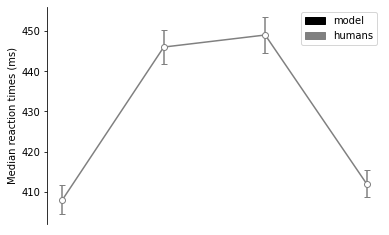

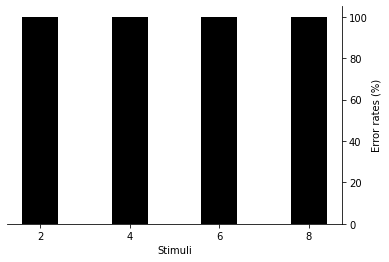

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

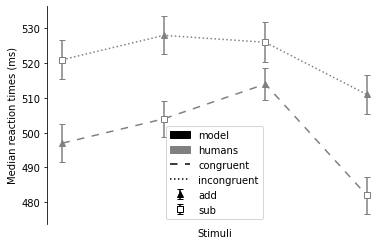

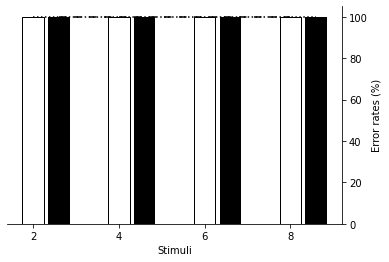

params: [0.5337556482951716, 8.263648109856772, 0.1229756822457239, 7957, 0.5260978979615557, 22.60010200131526, 7, 4.2249690692663195, 0.00993059593544746]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc944ae9f90>
xp = <experiments.Xp1 object at 0x7fc95d7b8a50>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93c2ce090>
	 seed 2/10
running run_seed2_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc956330f50>
xp = <experiments.Xp1 object at 0x7fc962da3e50>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc929128dd0>
	 seed 3/10
running run_seed3_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95352fb90>
xp = <experiments.Xp1 object at 0x7fc962da3390>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9535191d0>
	 seed 4/10
running run_seed4_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93c2f1e10>
xp = <experiments.Xp1 object at 0x7fc93d03dd50>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc943341490>
	 seed 5/10
running run_seed5_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae7c19d0>
xp = <experiments.Xp1 object at 0x7fc93c2e99d0>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93a387650>
	 seed 6/10
running run_seed6_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9296d4150>
xp = <experiments.Xp1 object at 0x7fc998418d50>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9534eaad0>
	 seed 7/10
running run_seed7_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=112, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93b173350>
xp = <experiments.Xp1 object at 0x7fc93be15210>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9bc214510>
	 seed 8/10
running run_seed8_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc952ae5690>
xp = <experiments.Xp1 object at 0x7fc9bc077cd0>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9af64ad10>
	 seed 9/10
running run_seed9_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc94331a850>
xp = <experiments.Xp1 object at 0x7fc943e8f990>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9af0bc150>
	 seed 10/10
running run_seed10_crosstalk0.5337556482951716_sevid8.263648109856772_nsamples7957_combscale0.5260978979615557_procfb22.60010200131526_D112_gwscale4.2249690692663195_prevsyn0.00993059593544746


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5260978979615557
s_crosstalk = 0.5337556482951716
s_evidence = 8.263648109856772
n_samples = 7957
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9440fdb50>
xp = <experiments.Xp1 object at 0x7fc9bc200710>
proc_feedback = 22.60010200131526
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.00993059593544746
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.2249690692663195
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ade50050>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


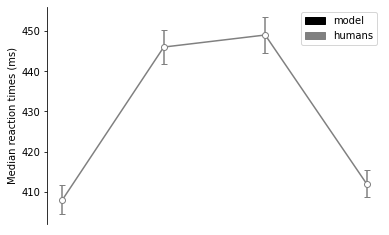

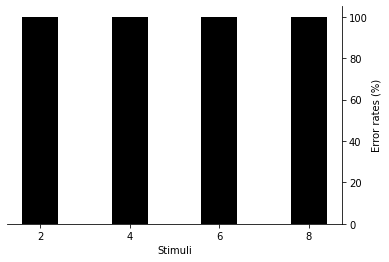

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

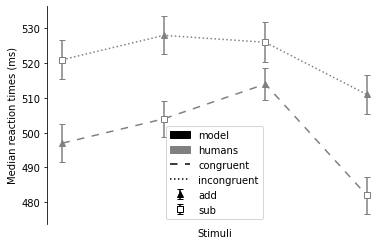

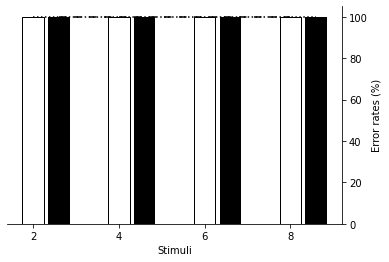

params: [0.5162402035294575, 9.061940417763484, 0.08317420100022573, 7140, 0.5792403585796019, 3.655797872872327, 8, 4.020394094800483, 0.009479801814204183]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc943e8f350>
xp = <experiments.Xp1 object at 0x7fc95ec13450>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc928a403d0>
	 seed 2/10
running run_seed2_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93c914210>
xp = <experiments.Xp1 object at 0x7fc9ade579d0>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9adf361d0>
	 seed 3/10
running run_seed3_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9aea79c10>
xp = <experiments.Xp1 object at 0x7fc93cabb710>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae814390>
	 seed 4/10
running run_seed4_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95daa7c90>
xp = <experiments.Xp1 object at 0x7fc93b1780d0>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc929a7e390>
	 seed 5/10
running run_seed5_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d24c2d0>
xp = <experiments.Xp1 object at 0x7fc95da95c50>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9287cc2d0>
	 seed 6/10
running run_seed6_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93b6b63d0>
xp = <experiments.Xp1 object at 0x7fc93d0cde10>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93c607e90>
	 seed 7/10
running run_seed7_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93bbeb110>
xp = <experiments.Xp1 object at 0x7fc9440ea890>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc944caa0d0>
	 seed 8/10
running run_seed8_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93bc15250>
xp = <experiments.Xp1 object at 0x7fc9440ea550>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc939a70890>
	 seed 9/10
running run_seed9_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95cc6efd0>
xp = <experiments.Xp1 object at 0x7fc95a3a46d0>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9287d3250>
	 seed 10/10
running run_seed10_crosstalk0.5162402035294575_sevid9.061940417763484_nsamples7140_combscale0.5792403585796019_procfb3.655797872872327_D128_gwscale4.020394094800483_prevsyn0.009479801814204183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5792403585796019
s_crosstalk = 0.5162402035294575
s_evidence = 9.061940417763484
n_samples = 7140
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93a38c8d0>
xp = <experiments.Xp1 object at 0x7fc95ca3fd10>
proc_feedback = 3.655797872872327
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.009479801814204183
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 4.020394094800483
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc939ca03d0>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


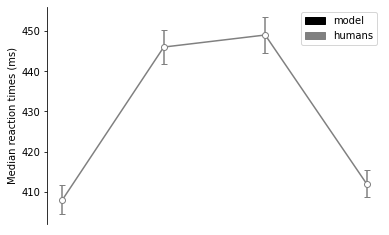

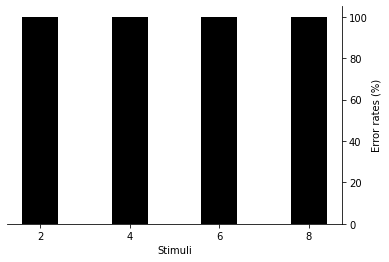

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

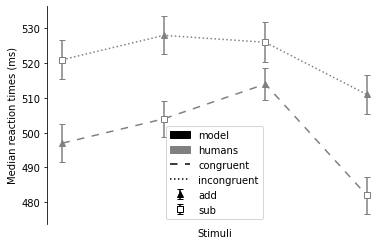

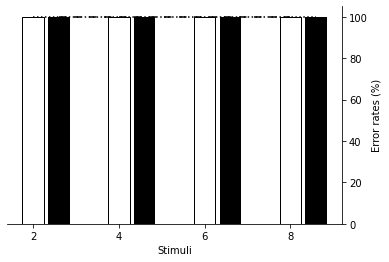

params: [0.6568543488007524, 7.5103373646043785, 0.11768972859959896, 7652, 0.5361261020211621, 54.61045603557647, 7, 3.8131574425224444, 0.011902045877551452]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93c6b5b90>
xp = <experiments.Xp1 object at 0x7fc95ca3fd10>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93a587bd0>
	 seed 2/10
running run_seed2_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9984246d0>
xp = <experiments.Xp1 object at 0x7fc93ced12d0>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc998432d90>
	 seed 3/10
running run_seed3_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae65a550>
xp = <experiments.Xp1 object at 0x7fc9ade50310>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93c6b9150>
	 seed 4/10
running run_seed4_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc956321790>
xp = <experiments.Xp1 object at 0x7fc9440d5f10>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ad93b8d0>
	 seed 5/10
running run_seed5_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9084cd850>
xp = <experiments.Xp1 object at 0x7fc9999ac910>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc962f0e690>
	 seed 6/10
running run_seed6_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae15a410>
xp = <experiments.Xp1 object at 0x7fc944cc3690>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc955bfd6d0>
	 seed 7/10
running run_seed7_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=112, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9aedf5ad0>
xp = <experiments.Xp1 object at 0x7fc944cc37d0>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95cc8a390>
	 seed 8/10
running run_seed8_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9adcb6c50>
xp = <experiments.Xp1 object at 0x7fc94331ec50>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc953c219d0>
	 seed 9/10
running run_seed9_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93a5c87d0>
xp = <experiments.Xp1 object at 0x7fc928a66d90>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9984f1c50>
	 seed 10/10
running run_seed10_crosstalk0.6568543488007524_sevid7.5103373646043785_nsamples7652_combscale0.5361261020211621_procfb54.61045603557647_D112_gwscale3.8131574425224444_prevsyn0.011902045877551452


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5361261020211621
s_crosstalk = 0.6568543488007524
s_evidence = 7.5103373646043785
n_samples = 7652
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93953d390>
xp = <experiments.Xp1 object at 0x7fc93cddc910>
proc_feedback = 54.61045603557647
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.011902045877551452
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.8131574425224444
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95c00f350>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


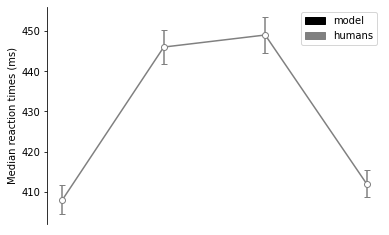

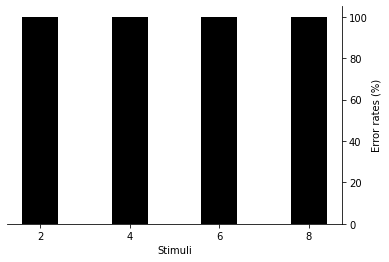

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

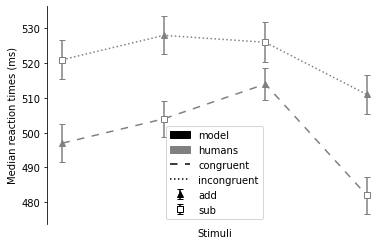

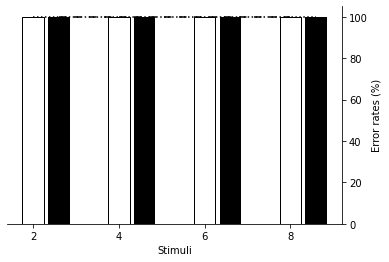

params: [0.559099759909339, 7.415756355193208, 0.13342631369005853, 7357, 0.5752788353175604, 83.82833326004216, 6, 3.9990545348141184, 0.005737920114006546]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95f6dbd10>
xp = <experiments.Xp1 object at 0x7fc9ad925b10>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9a3f4a990>
	 seed 2/10
running run_seed2_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae8272d0>
xp = <experiments.Xp1 object at 0x7fc93cb9ea10>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93b5da850>
	 seed 3/10
running run_seed3_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=20, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9ae659ed0>
xp = <experiments.Xp1 object at 0x7fc9af29d150>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae4e9a10>
	 seed 4/10
running run_seed4_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=19, similarity=0.11)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9295742d0>
xp = <experiments.Xp1 object at 0x7fc9ae67c650>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9984a3190>
	 seed 5/10
running run_seed5_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95c916f10>
xp = <experiments.Xp1 object at 0x7fc94412c2d0>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9440f8610>
	 seed 6/10
running run_seed6_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9af2f5f50>
xp = <experiments.Xp1 object at 0x7fc93d3de0d0>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9299206d0>
	 seed 7/10
running run_seed7_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d0d5b10>
xp = <experiments.Xp1 object at 0x7fc93caac890>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc929110150>
	 seed 8/10
running run_seed8_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93d886510>
xp = <experiments.Xp1 object at 0x7fc93d0d5d90>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc95d56bad0>
	 seed 9/10
running run_seed9_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 9
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9449aaa10>
xp = <experiments.Xp1 object at 0x7fc94427cfd0>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc952db7250>
	 seed 10/10
running run_seed10_crosstalk0.559099759909339_sevid7.415756355193208_nsamples7357_combscale0.5752788353175604_procfb83.82833326004216_D96_gwscale3.9990545348141184_prevsyn0.005737920114006546


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=19, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 10
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5752788353175604
s_crosstalk = 0.559099759909339
s_evidence = 7.415756355193208
n_samples = 7357
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9561cd710>
xp = <experiments.Xp1 object at 0x7fc954b97650>
proc_feedback = 83.82833326004216
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.005737920114006546
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.9990545348141184
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9adc71290>
compare error rates: False


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rmse : 1496.2751247618935


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


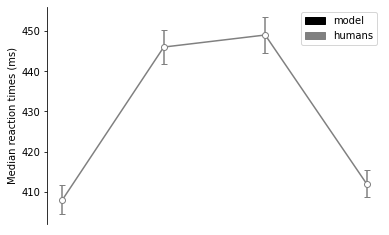

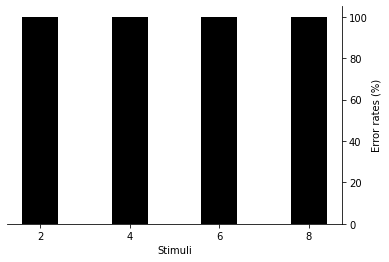

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arr

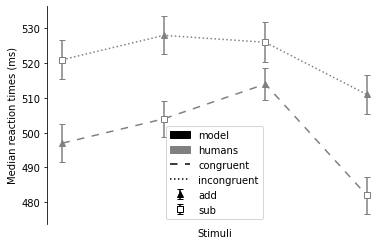

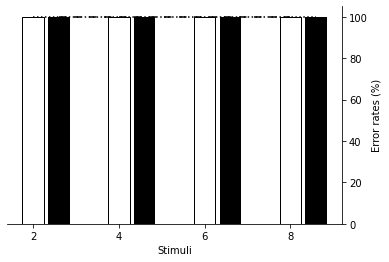

params: [0.357998215413057, 6.815529656580293, 0.14848178143736906, 7817, 0.5776516507724887, 0.85, 7, 3.814964997322768, 0.0060979142405241825]
Simulating...
	 seed 1/10
running run_seed1_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9557ecd50>
xp = <experiments.Xp1 object at 0x7fc92993b450>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9ae53d990>
	 seed 2/10
running run_seed2_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95cca5b50>
xp = <experiments.Xp1 object at 0x7fc9561cd0d0>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc965ec7f90>
	 seed 3/10
running run_seed3_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9afbf98d0>
xp = <experiments.Xp1 object at 0x7fc95f3c3210>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc9996e98d0>
	 seed 4/10
running run_seed4_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc99844a910>
xp = <experiments.Xp1 object at 0x7fc93cac34d0>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc956f04b90>
	 seed 5/10
running run_seed5_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 5
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc93bdf2e50>
xp = <experiments.Xp1 object at 0x7fc953f33b90>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93da12290>
	 seed 6/10
running run_seed6_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 6
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95ea47690>
xp = <experiments.Xp1 object at 0x7fc93c16b810>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d033210>
	 seed 7/10
running run_seed7_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=112, M=20, similarity=0.10)
  len(self._key2idx), best_sim))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 7
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc9433eb690>
xp = <experiments.Xp1 object at 0x7fc95ea451d0>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc943b5cc50>
	 seed 8/10
running run_seed8_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 8
backend = 'nengo_ocl'
dt = 0.001
neuron_type = 'default'
n_neurons_scale = 1
n_neurons_scale_combined = 0.5776516507724887
s_crosstalk = 0.357998215413057
s_evidence = 6.815529656580293
n_samples = 7817
t_senso = 0
vocab = <nengo_spa.vocabulary.Vocabulary object at 0x7fc95c748910>
xp = <experiments.Xp1 object at 0x7fc943b77cd0>
proc_feedback = 0.85
proc_feedback_synapse = 0.005
prev_feedback_synapse = 0.0060979142405241825
GW_feedback = 1
GW_threshold = 0.5
GW_scale = 3.814964997322768
BG_thr = 0.1
BG_bias = 0.5
integrator_reset = False
data = <data.Data object at 0x7fc93d4bfc10>
	 seed 9/10
running run_seed9_crosstalk0.357998215413057_sevid6.815529656580293_nsamples7817_combscale0.5776516507724887_procfb0.85_D112_gwscale3.814964997322768_prevsyn0.0060979142405241825


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [6]:
candidates = [
#     [0.8463109166860173, 9.699102753984128, 0.10490963191457431, 4490, 0.30661949235684305, 0.7672069544735085, 9, 14.258939431622663, 0.009752574209324755],
#     [0.2730499742167474, 5.888648019523452, 0.13410560801378912, 5971, 0.704488687679921, 0.7058939394845265, 4, 9.399259575828562, 0.004558162438549226],
#     [0.6477493997733477, 10.30908633197453, 0.15264661054302442, 3630, 0.777509517858044, 0.9406709148170056, 2, 15.445163019218862, 0.0033282562052117833],
#     [0.5139976329388788, 18.414177174564905, 0.05056535015925409+.05, 6645, 0.19536987556006435, 0.9280077706286105, 10, 9.018652132500627, 0.008712265216087306],
#     [0.20165971807052613, 6.02436589212857, 0.052368294221117676, 3671, 0.952773318599222, 0.8549823885290033, 9, 19.303761307498952, 0.002190532260918006],
#     [0.0525024818369212, 10.51731878872845, 0.17483188542668088-.03, 6763, 0.15921329528407605, 0.9605323324085461, 4, 11.643657838449212, 0.0039650138272247695],
#     [0.8733180849349123, 13.312279867708797, 0.12402602637560184, 1377, 0.7444200784558392, 0.7606842768863016, 8, 10.241912805134255, 0.0180966165099226],
#     [0.2944273971744243, 18.563330162854065, 0.17364336574817466-.05, 2635, 0.1988937186163001, 0.9667409857936884, 5, 22.835938723416852, 0.01253263841620225],
#     [0.8673512747099721, 17.42630133484004, 0.08737077088009122, 7493, 0.5149702556805613, 0.5719394835567857, 4, 5.279414941493777, 0.011568166413305485],
#     [0.29070376432314776, 19.354436427701124-1, 0.11779345826490306, 1618, 0.3894202579288364, 0.9494757711007107, 9, 6.085043480213131, 0.005625260175824355],
    [0.5141590329358398, 7.484787786686427, 0.1695190334302882-.05, 7665, 0.5540877322244593, 0.9073665908931585, 7, 4.036586424613745, 0.010791654845471253],
#     [0.6648360665714368, 18.479692260914195, 0.07073469694820798+.05, 8269, 0.6855980901062497, 0.6222927983911885, 4, 8.202553178710245, 0.00464703780502297],
#     [0.9233831056468913, 8.662400395267506, 0.12977651996482037, 119, 0.5079431142449035, 0.7161557738927364, 6, 24.184459527068782, 0.01764209573510557]
]

rmse_res = gp_minimize(create_evaluation_function(plot=True, n_seeds=10, compare_errorates=False), 
    dimensions=[
        Real(0.3, .7, name="crosstalk"), # crosstalk
        Real(6, 10, name="evidence strength"), # evidence strength
        Real(.08, .15, name="senso"), # sensory delay
        Integer(7000, 8000, name="number of samples"), # number of samples
        Real(.5, .6, name="scale combined"), # n_neurons_scale_combined
        Real(.85, 95, name="processor feedback"), # processor feedback
        Integer(6, 8, name="dimensions"), # dimensions (*16)
        Real(3.75, 4.25, name="GW scale"), # GW scale
        Real(0.005, 0.015, name="PREV feedback synapse"), # PREV feedback synapse
    ],
#     x0=[
#         .15, # crosstalk
#         15, # evidence strength
#         .1, # sensory delay
#         N_SAMPLES,
#         N_NEURONS_SCALE_COMBINED,
#         PROC_FDBCK,
#         int(D/16),
#         GW_SCALE,
#         .01 # prev fb syn
#     ],
    n_calls=100,
    random_state=STARTING_SEED,
    x0=candidates[0],
    n_random_starts=10,
               
)

# Other losses

In [ ]:

def evaluation_function(params):
    
    print("params:", params)
    data = []
    
    D = params[6]*16
    
#     return 0
        
    print('Simulating...')
    for i,seed in enumerate(range(STARTING_SEED, STARTING_SEED+N_SEEDS)):
        print('\t seed '+str(i+1)+'/'+str(N_SEEDS))
        data_filename = 'run_seed'+str(seed)+'_crosstalk'+str(params[0])+'_sevid'+str(params[1])+'_nsamples'+str(params[3])+'_combscale'+str(params[4])+'_procfb'+str(params[5])+'_D'+str(D)+'_gwscale'+str(params[7])+'_prevsyn'+str(params[8])      
        
        try:
            seed_data = pd.read_pickle(data_dir+'/'+data_filename+'.csv')

        except FileNotFoundError:
            xp = create_xp(N_BLOCKS_PER_OPERATION, N_TRIALS_PER_DIGIT, N_DIFFERENT_DIGITS, N_DIFFERENT_OPERATIONS, STIM_DURATION, FIX_DURATION, seed)
            results = ExperimentRun().run(
                n_neurons_scale=N_NEURONS_SCALE,
                n_neurons_scale_combined=params[4],
                s_crosstalk=params[0],
                s_evidence=params[1],
                n_samples=int(params[3]),
                t_senso=0,
                vocab=create_vocab(D, seed),
                xp=xp,
                integrator_reset=INTEGRATOR_RESET,
                proc_feedback=params[5],
                proc_feedback_synapse=PROC_FDBCK_SYN,
                prev_feedback_synapse=params[8],
                GW_feedback=GW_FDBCK,
                GW_scale=params[7],
                BG_thr=BG_THR,
                BG_bias=BG_BIAS,
                seed=seed,
                backend="nengo_ocl",
                data_dir=data_dir,
                data_filename=data_filename,
                plt=False
            )

            seed_data = results['data'].df

            seed_data.to_pickle(data_dir+'/'+data_filename+'.csv')
        data.append(seed_data)
        
        
    data = Data(pd.concat(data))
    data.df['rt'] += params[2]*1000
    print('error rate:', data.error_rate)
    return data.error_rate * 100

error_rates_res = gp_minimize(evaluation_function, 
    dimensions=[
        Real(0, 1, name="crosstalk"), # crosstalk
        Real(5, 20, name="evidence strength"), # evidence strength
        Real(0, .2, name="senso"), # sensory delay
        Integer(100, 10000, name="number of samples"), # number of samples
        Real(.1, 1, name="scale combined"), # n_neurons_scale_combined
        Real(.5, 1, name="processor feedback"), # processor feedback
        Integer(2, 10, name="dimensions"), # dimensions (*16)
        Real(1, 30, name="GW scale"), # GW scale
        Real(.002, .02, name="PREV feedback synapse"), # PREV feedback synapse
    ],
    x0=res['x_iters'],
    n_calls=100,
    n_random_starts=0,
    random_state=STARTING_SEED
               
)


with open(data_dir+"/error_rates_res.pickle", 'wb') as handle:
    pickle.dump(error_rates_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

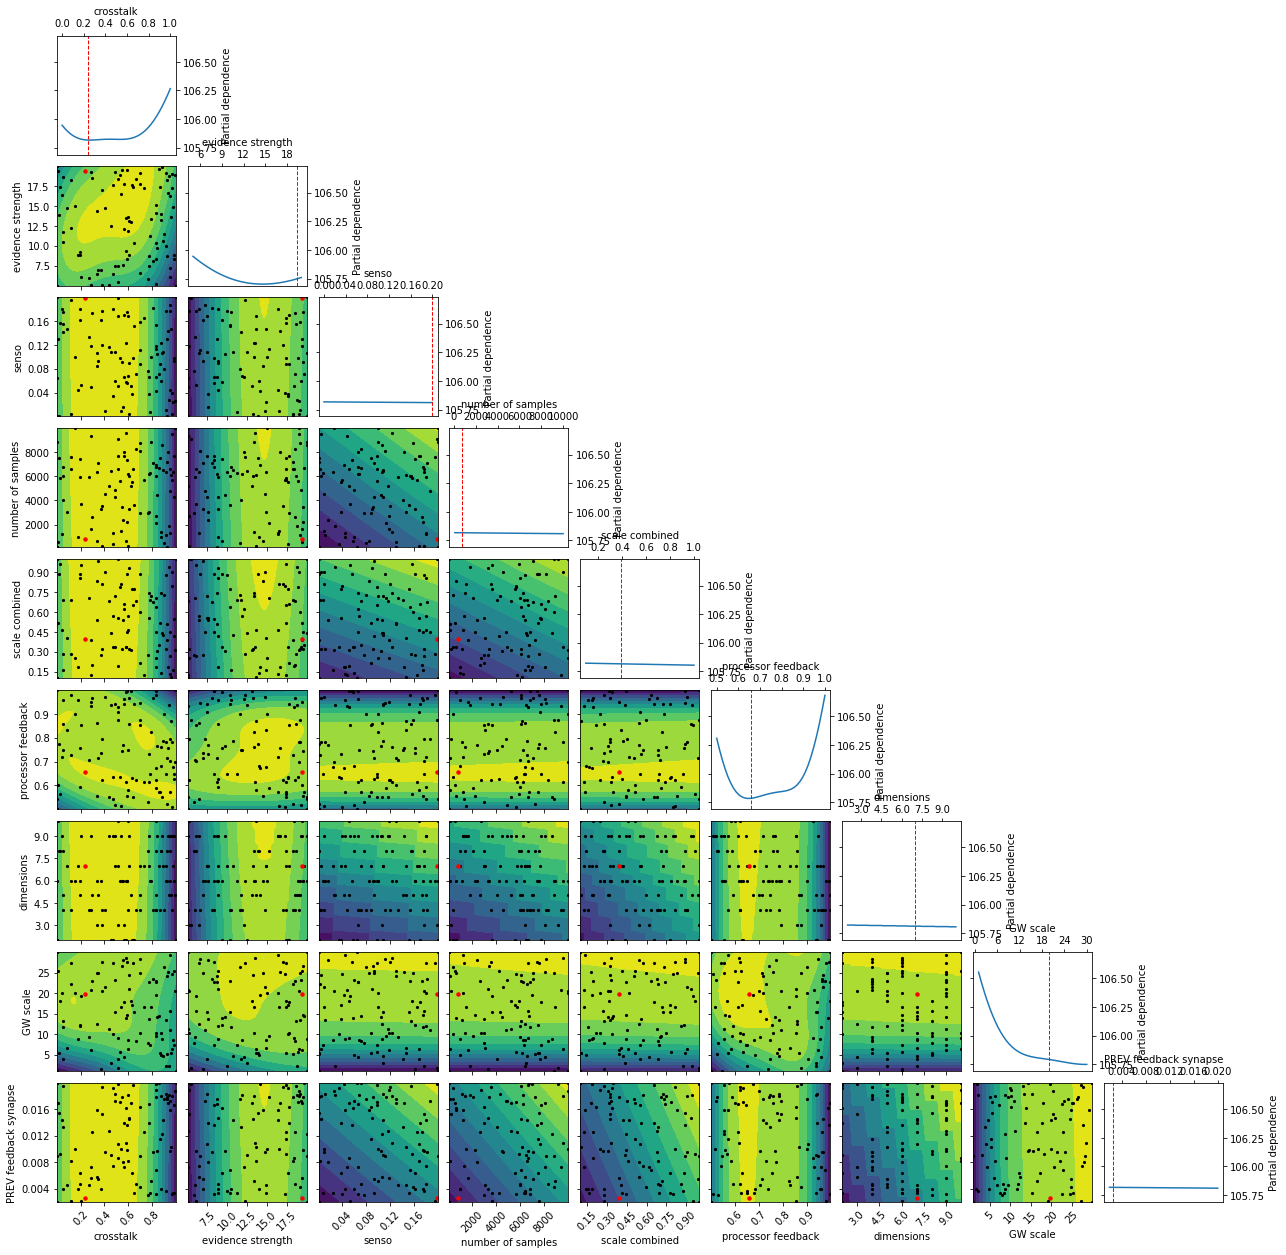

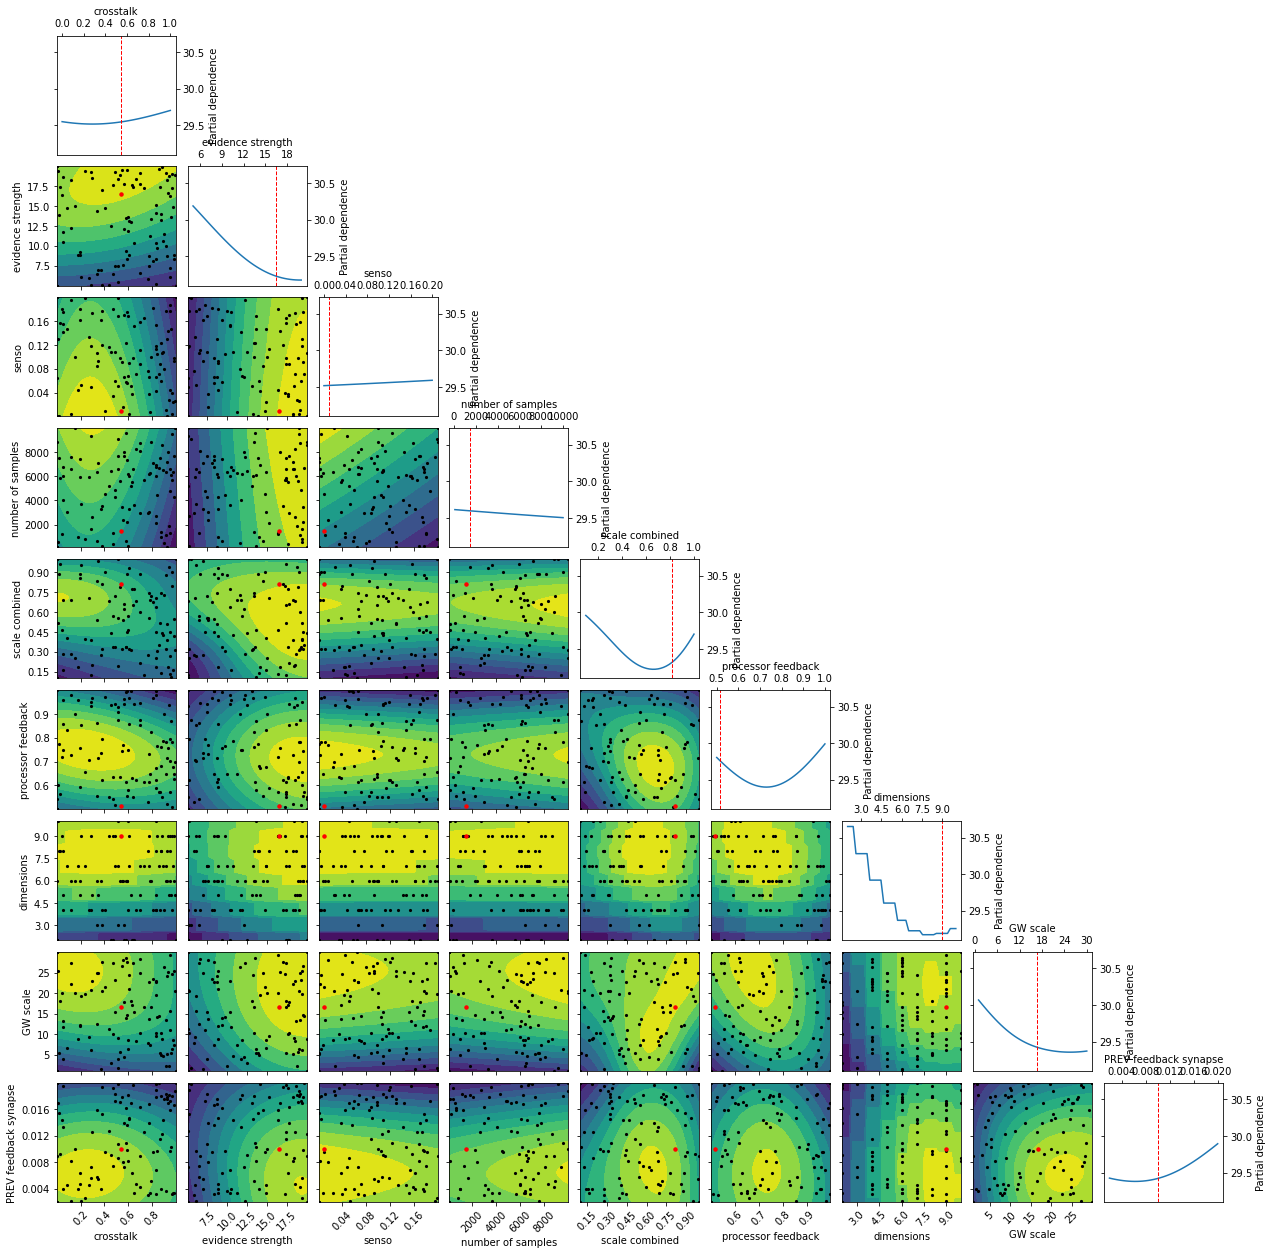

In [26]:
# plot_evaluations(rmse_res)
_ = plot_objective(rmse_res, n_samples=40)

# plot_evaluations(rmse_res)
_ = plot_objective(custom_res, n_samples=40)

# plot_evaluations(error_rates_res)
_ = plot_objective(error_rates_res, n_samples=40)

In [25]:
print(rmse_res['x'])
print(rmse_res['fun'])

print(error_rates_res['x'])
print(error_rates_res['fun'])

[0.23664549801929685, 19.465672488137482, 0.19881264140562196, 784, 0.39417040141414206, 0.6581000330311513, 7, 19.768952567994514, 0.002604488011812599]
22.342239382898708
[0.5406005088236441, 16.482276566613066, 0.00906914571493065, 1486, 0.8131632272164174, 0.5149006790911966, 9, 16.68285749842798, 0.01006364326556753]
0.0
